In [1]:
#%% Import

import numpy as np
import pandas as pd
import scanpy as sc # v1.4.3
import scrublet as scr
import sys
import bbknn
from statsmodels import robust
import matplotlib.pyplot as plt
from pygam import LogisticGAM
from scipy import sparse, io
import anndata
import os.path
import scipy
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize
import pickle

/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}




***Combine objects and build DS and non-DC data***




In [7]:
bm = sc.read_h5ad('bm.h5ad')
downs = sc.read_h5ad('downs.h5ad')

In [8]:
bm.obs['Status']='healthy'
downs.obs['Status']='downs'

In [10]:
downs.obs = downs_meta
bm.obs = bm_meta

In [11]:
sc.pp.subsample(bm, fraction=0.1)

In [12]:
total = bm.concatenate(downs)

/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/anndata/_core/merge.py:461: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  obs = pd.concat([a.obs for a in adatas], ignore_index=True)
/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/anndata/_core/merge.py:513: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  UserWarning,


In [91]:
genes = total.var.copy()
genes['gene_short_name'] = genes.index
genes[['gene_short_name']].to_csv('total_genes.csv', header=True)

b = total.obs.index
b = pd.DataFrame(b)
b.to_csv('total_cell_names.csv')


metadata = total.obs['clustering_5c']
metadata.to_csv('total_metadata.csv')


a = total.T.X.toarray()
a = pd.DataFrame(a)
a.index = genes['gene_short_name']
a.columns = total.obs.index
a.to_csv('total.txt', sep="\t")

/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  # This is added back by InteractiveShellApp.init_path()


In [21]:
sc.pp.normalize_total(total, target_sum=1e4)
sc.pp.log1p(total)
sc.pp.highly_variable_genes(total, min_mean=0.0125, max_mean=5, min_disp=0.5)
total.raw = total
total = total[:, total.var.highly_variable]

In [24]:
total.obs.clustering_5c = total.obs.clustering_5c.astype('category')
total.obs.clustering_5c.cat.categories

Trying to set attribute `.obs` of view, copying.


Index(['B_lineage', 'HSC', 'MEMP', 'MK', 'NK', 'T cell', 'T_cell', 'basophil',
       'eosinophil', 'erythroid', 'lymphoid_progenitor', 'mast cell',
       'mast_cell', 'monocyte', 'myeloid DC', 'myeloid progenitor',
       'myeloid_DC', 'myeloid_progenitor', 'neutrophil', 'pDC', 'stroma'],
      dtype='object')

In [25]:
sc.pp.scale(total, max_value=10)

In [26]:
sc.tl.pca(total, svd_solver='arpack')

In [15]:
total.obs.clustering = total.obs.clustering.astype('category')
total.obs.clustering.cat.categories

Index(['B_lineage', 'Basophil', 'Eosinophil', 'Erythroid', 'HSC',
       'Lymphoid_precursor', 'MEMP', 'MK', 'Mast_cell', 'Monocyte',
       'Myeloid_DC', 'Myeloid_precursor', 'NK', 'Neutrophil', 'Stroma',
       'T_cell', 'pDC'],
      dtype='object')

In [16]:
bbknn.bbknn(total, batch_key = 'lanes')

In [17]:
sc.tl.umap(total)

... storing 'Status' as categorical
... storing 'age' as categorical
... storing 'april_cell.labels' as categorical
... storing 'auto_prd' as categorical
... storing 'cell.labels' as categorical
... storing 'doublets' as categorical
... storing 'fetal.ids' as categorical
... storing 'gender' as categorical
... storing 'is_doublet' as categorical
... storing 'is_doublet_poptrim' as categorical
... storing 'is_doublet_wolock' as categorical
... storing 'lanes' as categorical
... storing 'mad_prd' as categorical
... storing 'orig.ident' as categorical
... storing 'processing.type' as categorical
... storing 'sequencing.type' as categorical
... storing 'sort.ids' as categorical


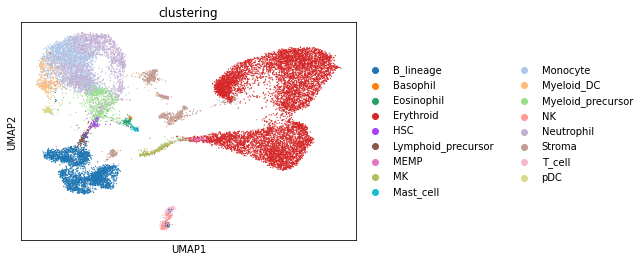

In [18]:
sc.pl.umap(total, color=['clustering'], legend_loc='right margin')

In [19]:
total.write('total.h5ad')



***PySCENIC of total data***



In [43]:
os.chdir('/home/ngr18/hcaskin/pySCENIC')

In [6]:
os.chdir('/home/ngr18/bone_marrow')
total = sc.read_h5ad('total.h5ad')
os.chdir('/home/ngr18/hcaskin/pySCENIC')

In [27]:
import os
import glob
import pickle
import pandas as pd
import numpy as np

from dask.diagnostics import ProgressBar

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

import seaborn as sns

DATA_FOLDER="/home/ngr18/hcaskin/pySCENIC"
RESOURCES_FOLDER="/home/ngr18/hcaskin/pySCENIC/resources"
DATABASE_FOLDER = "/home/ngr18/hcaskin/pySCENIC/databases"
DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.feather")
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.hgnc-m0.001-o0.0.tbl")
MM_TFS_FNAME = os.path.join(RESOURCES_FOLDER, 'lambert2018.txt')
SC_EXP_FNAME = os.path.join(RESOURCES_FOLDER, "data.csv")
REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons.p")
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "motifs.csv")

In [28]:
ex_matrix = pd.DataFrame(total.X)
ex_matrix.columns = total.var.index
ex_matrix.index = total.obs.index

In [29]:
tf_names = load_tf_names(MM_TFS_FNAME)

In [31]:
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr")]

In [ ]:
adjacencies = grnboost2(ex_matrix, tf_names=tf_names, verbose=True)

preparing dask client
parsing input
creating dask graph


/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/arboreto/algo.py:214: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  expression_matrix = expression_data.as_matrix()


5 partitions
computing dask graph


In [3]:
os.chdir('/home/ngr18/bone_marrow')
adjacencies.to_csv('adjacencies.csv')

NameError: name 'adjacencies' is not defined

In [ ]:
type(adjacencies)

In [ ]:
modules = list(modules_from_adjacencies(adjacencies, ex_matrix))

In [ ]:
import pickle
with open("modules.txt", "wb") as fp:
    pickle.dump(modules, fp)

In [ ]:
with ProgressBar():
    df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

In [ ]:
regulons = df2regulons(df)

In [ ]:
df.to_csv(MOTIFS_FNAME)
with open(REGULONS_FNAME, "wb") as f:
    pickle.dump(regulons, f)

In [ ]:
SCHEDULER="127.0.0.1:12345"

In [ ]:
df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

In [ ]:
auc_mtx = aucell(ex_matrix, regulons, num_workers=4)
sns.clustermap(auc_mtx, figsize=(8,8))

In [ ]:
auc_mtx.to_csv('full_mtx_bm_data.csv')

In [ ]:
os.chdir('/home/ngr18/bone_marrow')
total = sc.read_h5ad('total.h5ad')
os.chdir('/home/ngr18/hcaskin/pySCENIC')


***Restart***



In [3]:
os.chdir('/home/ngr18/hcaskin/pySCENIC')
auc_mtx = pd.read_csv('full_mtx_bm_data.csv', index_col = 0)
os.chdir('/home/ngr18/bone_marrow')

In [53]:
total = sc.read_h5ad('total.h5ad')

In [57]:
a = total.obs
a = a.drop(a.columns[0], axis=1)

a.index = a.index.map(lambda x: str(x)[:-2])
b = pd.concat([a, meta], axis=1, join='inner')

In [64]:
total.obs = b

In [65]:
total.obs['combined'] = total.obs['clustering_5c'].astype(str) + '_' + total.obs['Status'].astype(str)

In [66]:
rss_cellType = regulon_specificity_scores(auc_mtx, total.obs['clustering_5c'])

In [67]:
###calculate top regulons for each cluster
cats = sorted(list(set(total.obs['clustering_5c'])))

topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

ValueError: num must be 1 <= num <= 20, not 21

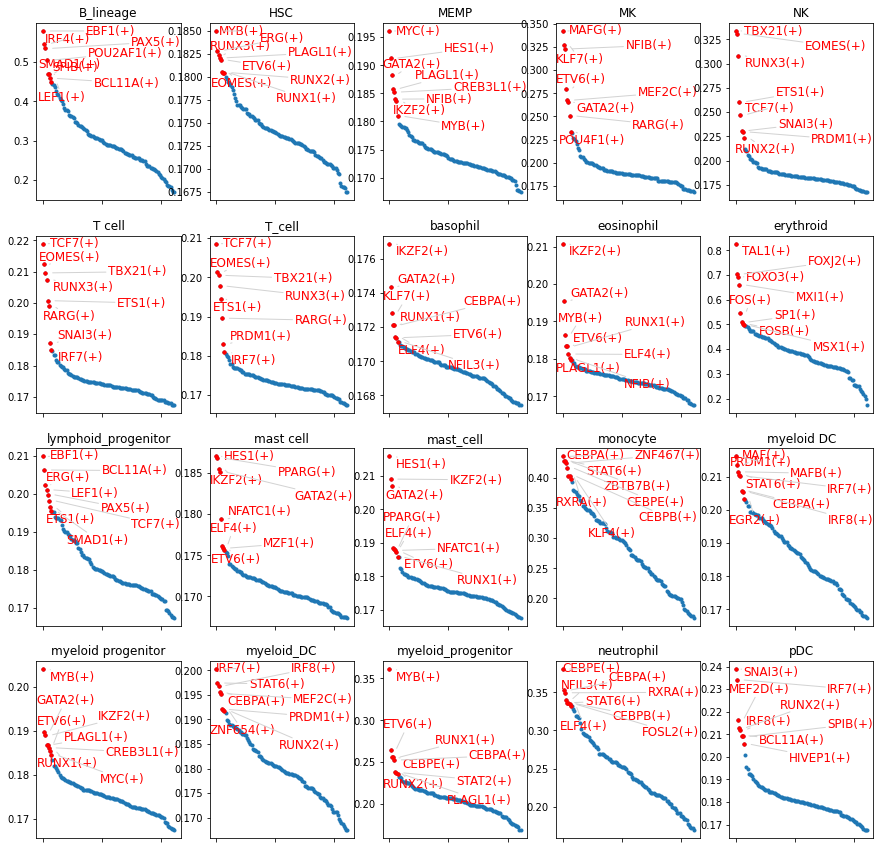

In [68]:
cats = sorted(list(set(total.obs['clustering_5c'])))

fig = plt.figure(figsize=(15, 15))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(4,5,num)
    plot_rss(rss_cellType, c, top_n=8, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })

plt.savefig("bm_regulons_by_cluster.pdf", dpi=600, bbox_inches = "tight")
plt.show()

In [9]:
total.obs = pd.concat([total.obs, auc_mtx], axis=1, join='inner')

... storing 'combined' as categorical


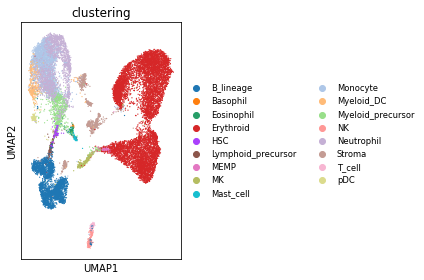

In [10]:
sc.pl.umap(total, color=['clustering'], legend_loc='right margin',legend_fontsize = 'small',
          ncols = 1, save = 'combined_umap_regulons.pdf')

/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


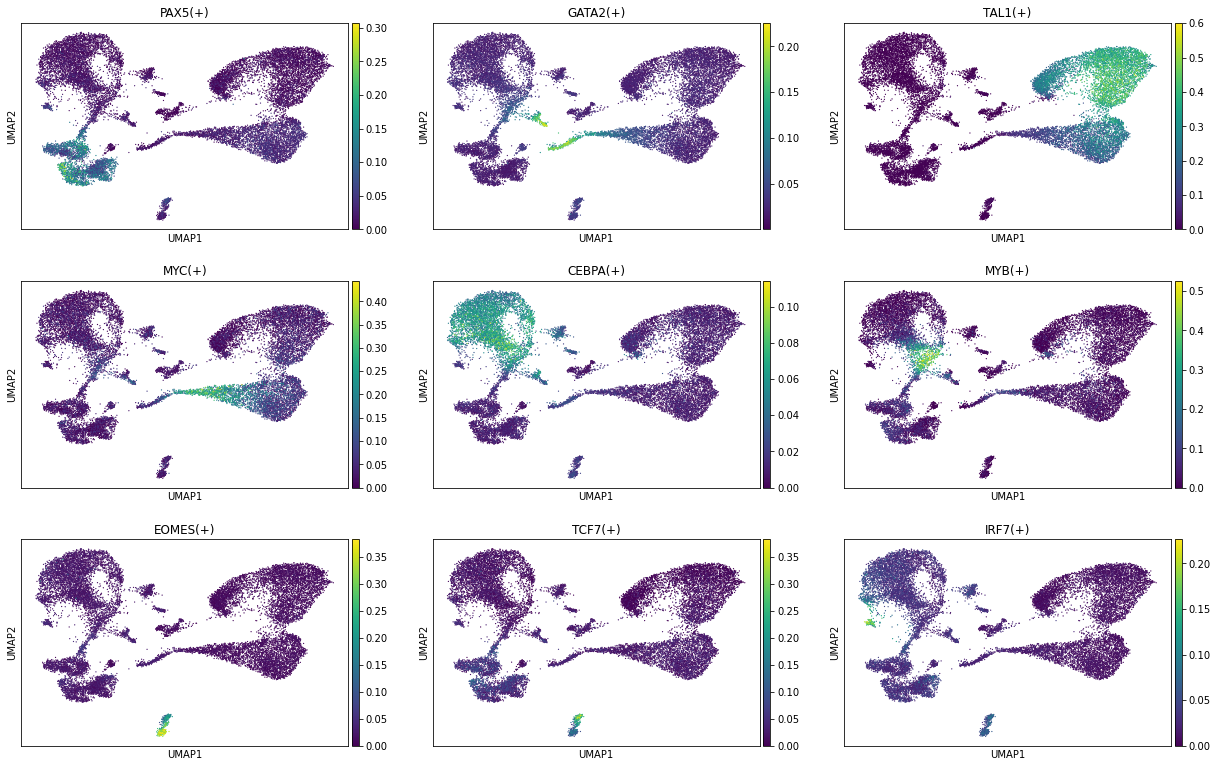

In [135]:
sc.pl.umap(total, color=['PAX5(+)', 'GATA2(+)', 'TAL1(+)', 'MYC(+)', 
                         'CEBPA(+)', 'MYB(+)', 'EOMES(+)', 'TCF7(+)', 'IRF7(+)'], legend_loc='on data',
          ncols = 3, save = 'marker_umap_regulons.pdf')



***Significance testing - export to R***



In [6]:
os.chdir('/home/ngr18/hcaskin/pySCENIC')
auc_mtx = pd.read_csv('full_mtx_bm_data.csv', index_col = 0)
os.chdir('/home/ngr18/bone_marrow')

In [77]:
auc_mtx.combined = total.obs.combined
auc_mtx.clustering_5c = total.obs.clustering_5c
auc_mtx.Status = total.obs.Status

/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [95]:
auc_mtx.index = auc_mtx.index.map(lambda x: str(x)[:-2])

In [96]:
###Myeloid
HSC_AUC = auc_mtx[(auc_mtx.combined == 'HSC_downs') | (auc_mtx.combined == 'HSC_healthy')]
MEMP_AUC = auc_mtx[(auc_mtx.combined == 'MEMP_downs') | (auc_mtx.combined == 'MEMP_healthy')]
MK_AUC = auc_mtx[(auc_mtx.combined == 'MK_downs') | (auc_mtx.combined == 'MK_healthy')]
Erythroid_AUC = auc_mtx[(auc_mtx.combined == 'erythroid_downs') | (auc_mtx.combined == 'erythroid_healthy')]
Myeloid_DC_AUC = auc_mtx[(auc_mtx.combined == 'myeloid DC_downs') | (auc_mtx.combined == 'myeloid_DC_healthy')]
Myeloid_precursor_AUC = auc_mtx[(auc_mtx.combined == 'myeloid progenitor_downs') | (auc_mtx.combined == 'myeloid_progenitor_healthy')]
Monocyte_AUC = auc_mtx[(auc_mtx.combined == 'monocyte_downs') | (auc_mtx.combined == 'monocyte_healthy')]
pDC_AUC = auc_mtx[(auc_mtx.combined == 'pDC_downs') | (auc_mtx.combined == 'pDC_healthy')]



In [97]:
os.chdir('/home/ngr18/bone_marrow')

HSC_AUC.to_csv('HSC_AUC.csv')
MEMP_AUC.to_csv('MEMP_AUC.csv')
MK_AUC.to_csv('MK_AUC.csv')
Erythroid_AUC.to_csv('Erythroid_AUC.csv')

In [ ]:
###Lymphoid


B_lineage_AUC = auc_mtx[(auc_mtx.combined == 'B_lineage_downs') | (auc_mtx.combined == 'B_lineage_healthy')]
Basophil_AUC = auc_mtx[(auc_mtx.combined == 'Basophil_downs') | (auc_mtx.combined == 'Basophil_healthy')]
Eosinophil_AUC = auc_mtx[(auc_mtx.combined == 'Eosinophil_downs') | (auc_mtx.combined == 'Eosinophil_healthy')]
Mast_cell_AUC = auc_mtx[(auc_mtx.combined == 'Mast_cell_downs') | (auc_mtx.combined == 'Mast_cell_healthy')]
NK_AUC = auc_mtx[(auc_mtx.combined == 'NK_downs') | (auc_mtx.combined == 'NK_healthy')]
Neutrophil_AUC = auc_mtx[(auc_mtx.combined == 'Neutrophil_downs') | (auc_mtx.combined == 'Neutrophil_healthy')]
T_cell_AUC = auc_mtx[(auc_mtx.combined == 'T_cell_downs') | (auc_mtx.combined == 'T_cell_healthy')]

In [124]:

Myeloid_DC_AUC.to_csv('Myeloid_DC_AUC.csv')
Myeloid_precursor_AUC.to_csv('Myeloid_precursor_AUC.csv')
Monocyte_AUC.to_csv('Monocyte_AUC.csv')
pDC_AUC.to_csv('pDC_AUC.csv')

In [ ]:


***Export genes of interest***



In [79]:
a = pd.DataFrame(total.X)
a.columns = total.var.index
a.index = total.obs.index

In [4]:
os.chdir('/home/ngr18/bone_marrow')
adjacencies = pd.read_csv("adjacencies.csv", index_col = 0)

/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
adjacencies.head

<bound method NDFrame.head of          TF  target    importance
68    GATA2    CPA3  6.299763e+02
61      LTF    CAMP  6.087837e+02
61      LTF    LCN2  5.879064e+02
68    GATA2     HDC  5.778452e+02
92     MXD3  NUSAP1  5.049396e+02
..      ...     ...           ...
69   PLSCR1  CACNB4  4.446842e-10
17   ZBTB7B  COL1A2  2.241185e-10
281    MBD2   FSTL1  1.746312e-10
337     DBP  COL1A1  1.331303e-10
28      HLX    LCAT  8.727528e-11

[1109041 rows x 3 columns]>

In [81]:
from pyscenic.utils import modules_from_adjacencies
modules = list(modules_from_adjacencies(adjacencies, a))


2020-07-20 18:26:51,075 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-20 18:26:51,077 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-20 18:27:10,536 - pyscenic.utils - INFO - Creating modules.


In [82]:
os.chdir('/home/ngr18/bone_marrow')
regulons = pickle.load( open( "full_bm_regulons.p", "rb" ) )


In [103]:
regulons[22].head

<bound method GeneSignature.head of Regulon(name='ERG(+)', gene2weight=<frozendict {'MMRN2': 59.7950818313931, 'TSC22D1': 136.39981797117332, 'PLVAP': 136.39981797117332, 'ENG': 59.7950818313931, 'SH3TC1': 59.7950818313931, 'ARHGAP27': 59.7950818313931, 'FERMT3': 136.39981797117332, 'PIK3CD': 24.10161992428241, 'PRKACB': 59.7950818313931, 'CYTL1': 15.66048269425583, 'SCN3A': 44.34158856905023, 'TCF4': 63.661713658598856, 'MAPRE2': 136.39981797117332, 'PCDH17': 70.75909840787621, 'TFPI': 63.661713658598856, 'PTPRB': 59.7950818313931, 'ARPP21': 63.661713658598856, 'RBMS3': 59.7950818313931, 'TMEM204': 44.34158856905023, 'MMRN1': 44.34158856905023, 'BLNK': 44.34158856905023, 'GAB3': 63.661713658598856, 'CYFIP2': 63.661713658598856, 'NEDD4': 63.661713658598856, 'ACAP2': 26.295278395720622, 'ZC3H12D': 32.83011814642677, 'VWF': 63.661713658598856, 'TMEM243': 24.10161992428241, 'TIE1': 63.661713658598856, 'STXBP5': 7.127752232824156, 'CCM2': 90.24634948496885, 'MAGED2': 14.72501070305958, 'C1

In [129]:
fos_genes = pd.DataFrame.from_dict(regulons[25].gene2weight, orient = 'index', columns = ['RUNX1'])
fos_genes.to_csv('fos_regulated_genes.csv')

In [104]:
erg_genes = pd.DataFrame.from_dict(regulons[22].gene2weight, orient = 'index', columns = ['ERG'])
erg_genes.to_csv('erg_regulated_genes.csv')

In [ ]:
tal1_genes = pd.DataFrame.from_dict(regulons[99].gene2weight, orient = 'index', columns = ['TAL1'])
tal1_genes.to_csv('tal1_regulated_genes.csv')

In [107]:
a = pd.DataFrame.from_dict(regulons[0].gene2weight, orient = 'index', columns = ['ERG'])
b = pd.DataFrame.from_dict(regulons[1].gene2weight, orient = 'index', columns = ['ETS1'])
c = pd.DataFrame.from_dict(regulons[2].gene2weight, orient = 'index', columns = ['GATA2'])
d = pd.DataFrame.from_dict(regulons[3].gene2weight, orient = 'index', columns = ['RUNX1'])


In [108]:
result = pd.concat([a,b,c,d], axis=1, sort=False)



**PySCENIC applied to myeloid compartment - data prep**



In [3]:
os.chdir('/home/ngr18/hcaskin/pySCENIC')

In [3]:
import os
import glob
import pickle
import pandas as pd
import numpy as np

from dask.diagnostics import ProgressBar

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

import seaborn as sns

DATA_FOLDER="/home/ngr18/hcaskin/pySCENIC"
RESOURCES_FOLDER="/home/ngr18/hcaskin/pySCENIC/resources"
DATABASE_FOLDER = "/home/ngr18/hcaskin/pySCENIC/databases"
DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.feather")
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.hgnc-m0.001-o0.0.tbl")
MM_TFS_FNAME = os.path.join(RESOURCES_FOLDER, 'lambert2018.txt')
SC_EXP_FNAME = os.path.join(RESOURCES_FOLDER, "data.csv")
REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons.p")
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "motifs.csv")

In [4]:
import os.path
os.chdir('/home/ngr18/bone_marrow')

In [5]:
bm = sc.read_h5ad('bm.h5ad')

In [6]:
bm.obs.clustering.cat.categories

Index(['B_lineage', 'Basophil', 'Eosinophil', 'Erythroid', 'HSC',
       'Lymphoid_precursor', 'MEMP', 'MK', 'Mast_cell', 'Monocyte',
       'Myeloid_DC', 'Myeloid_precursor', 'NK', 'Neutrophil', 'Stroma',
       'T_cell', 'pDC'],
      dtype='object')

In [8]:
bm.raw = bm

In [9]:
sc.pp.normalize_total(bm, target_sum=1e4)
sc.pp.log1p(bm)

In [10]:
sc.pp.highly_variable_genes(bm, n_top_genes = 3000)

In [11]:
bm = bm[:, bm.var.highly_variable]

In [12]:
print(sc.__version__)

1.5.1


In [13]:
### sc.tl.pca(bm, svd_solver='arpack')

In [14]:
embed = pd.read_csv('embed_full.csv', index_col = 0)
embed = np.array(embed)
bm.obsm['X_harmony'] = embed

In [15]:
bm = bm[bm.obs['cell.labels'].isin(['HSC', 'MPP myeloid', 'CMP', 'GMP', 'myeloid DC progenitor',
                                      'DC precursor', 'tDC', 'DC1', 'DC2', 'DC3', 'pDC'])]

In [31]:
sc.pp.neighbors(bm, n_neighbors=10, n_pcs=30, use_rep="X_harmony", key_added='harmony')

In [32]:
sc.tl.paga(bm, groups='cell.labels',  neighbors_key = 'harmony')

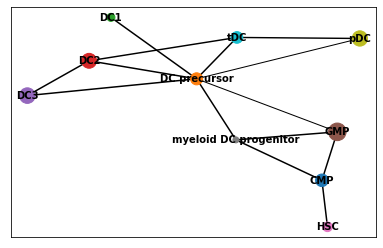

In [40]:
sc.pl.paga(bm, color=['cell.labels'], threshold = 0.65, edge_width_scale = 0.2, fontsize = 10, save='HSC_to_DC.png')

In [133]:
bm = bm.raw.to_adata()
bm.raw = bm

In [41]:
bm.write('HSC_to_DC.h5ad')

In [37]:
sc.tl.draw_graph(bm, init_pos='paga', neighbors_key = 'harmony')

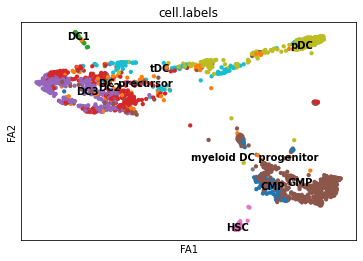

In [38]:
sc.pl.draw_graph(bm, color=['cell.labels'], legend_loc='on data')

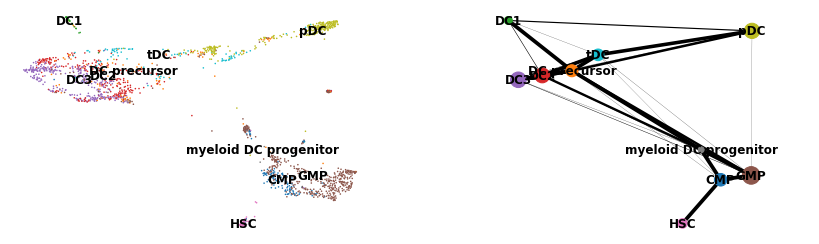

In [39]:
sc.pl.paga_compare(
    bm, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False)



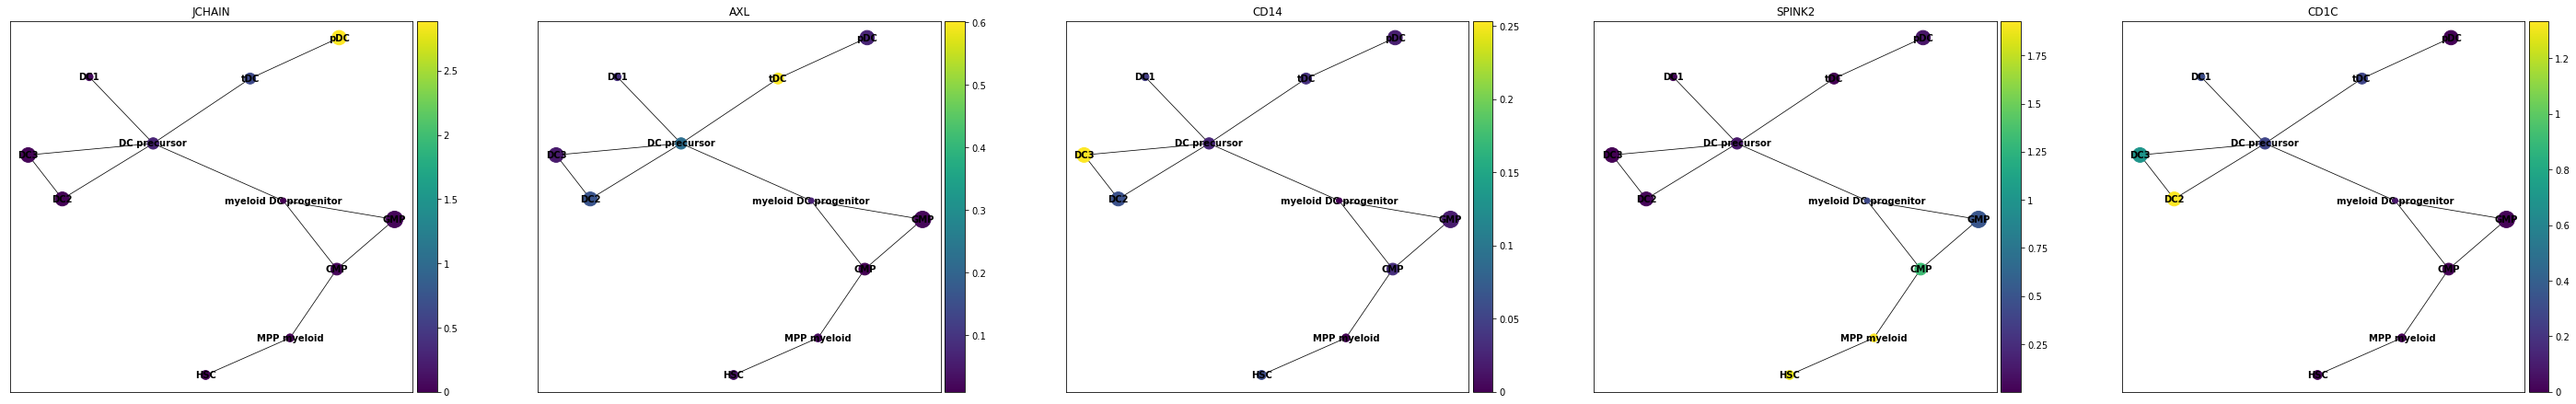

In [121]:
sc.pl.paga(bm, color=['JCHAIN', 'AXL', 'CD14', 'SPINK2', 'CD1C',], threshold = 1, edge_width_scale = 0.1, fontsize = 10)



***HSC to DC precursor pathway***



In [5]:
os.chdir('/home/ngr18/bone_marrow')
bm = sc.read_h5ad('HSC_to_DC.h5ad')

In [6]:
HSC = bm[bm.obs['cell.labels'].isin(['HSC', 'CMP', 'GMP', 'myeloid DC progenitor',
                                      'DC precursor'])]


In [7]:
sc.pp.neighbors(HSC, n_neighbors=10, n_pcs=30, use_rep="X_harmony")

In [8]:
sc.tl.paga(HSC, groups='cell.labels', neighbors_key = 'harmony')

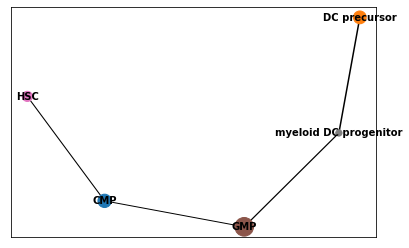

In [9]:
sc.pl.paga(HSC, color=['cell.labels'], threshold = 0.6, edge_width_scale = 0.2, fontsize = 10, 
           save = 'HSC_to_DC_paths.pdf')

In [10]:
HSC.uns['iroot'] = np.flatnonzero(HSC.obs['cell.labels']  == 'HSC')[0]

In [11]:
sc.tl.diffmap(HSC, neighbors_key='harmony')

In [12]:
sc.tl.dpt(HSC, neighbors_key='harmony')

In [13]:
ex_matrix = pd.DataFrame(HSC.X.toarray())
ex_matrix.columns = HSC.var.index
ex_matrix.index = HSC.obs.index

In [14]:
ex_matrix.shape

(733, 3000)

In [4]:
tf_names = load_tf_names(MM_TFS_FNAME)

In [5]:
tf_names

['TFAP2A',
 'TFAP2B',
 'TFAP2C',
 'TFAP2D',
 'TFAP2E',
 'ARID3A',
 'ARID3B',
 'ARID3C',
 'ARID5A',
 'ARID5B',
 'KDM5B',
 'ARID2',
 'AHCTF1',
 'AHDC1',
 'AKNA',
 'ASH1L',
 'CBX2',
 'DNTTIP1',
 'DOT1L',
 'GLYR1',
 'HMGA1',
 'HMGA2',
 'PHF20',
 'PHF21A',
 'PRR12',
 'SCML4',
 'SETBP1',
 'SRCAP',
 'C11orf95',
 'FAM200B',
 'SGSM2',
 'ZBED1',
 'ZBED2',
 'ZBED3',
 'ZBED4',
 'ZBED5',
 'ZBED6',
 'ZBED9',
 'AHR',
 'AHRR',
 'ARNT',
 'ARNT2',
 'ARNTL',
 'ARNTL2',
 'ASCL1',
 'ASCL2',
 'ASCL3',
 'ASCL4',
 'ASCL5',
 'ATOH1',
 'ATOH7',
 'ATOH8',
 'BHLHA15',
 'BHLHA9',
 'BHLHE22',
 'BHLHE23',
 'BHLHE40',
 'BHLHE41',
 'CCDC169-SOHLH2',
 'CLOCK',
 'EPAS1',
 'FERD3L',
 'FIGLA',
 'HAND1',
 'HAND2',
 'HELT',
 'HES1',
 'HES2',
 'HES3',
 'HES4',
 'HES5',
 'HES6',
 'HES7',
 'HEY1',
 'HEY2',
 'HEYL',
 'HIF1A',
 'HIF3A',
 'LYL1',
 'MAX',
 'MESP1',
 'MESP2',
 'MITF',
 'MLX',
 'MLXIP',
 'MLXIPL',
 'MNT',
 'MSC',
 'MSGN1',
 'MXD1',
 'MXD3',
 'MXD4',
 'MXI1',
 'MYC',
 'MYCL',
 'MYCN',
 'MYF5',
 'MYF6',
 'MYOD1',
 'MY

In [18]:
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr")]

In [19]:
adjacencies = grnboost2(ex_matrix, tf_names=tf_names, verbose=True)

preparing dask client
parsing input
creating dask graph


/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/arboreto/algo.py:214: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  expression_matrix = expression_data.as_matrix()


5 partitions
computing dask graph
shutting down client and local cluster
finished


In [20]:
modules = list(modules_from_adjacencies(adjacencies, ex_matrix))


2020-06-25 17:17:42,959 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-06-25 17:17:42,960 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-06-25 17:17:46,857 - pyscenic.utils - INFO - Creating modules.


In [21]:
with ProgressBar():
    df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

[                                        ] | 0% Completed |  8.2s


2020-06-25 17:18:18,240 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF791 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 12.5s


2020-06-25 17:18:22,551 - pyscenic.transform - WARNING - Less than 80% of the genes in ZGPAT could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 12.9s


2020-06-25 17:18:23,053 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[                                        ] | 0% Completed | 13.0s

[                                        ] | 0% Completed | 13.6s


2020-06-25 17:18:23,719 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF296 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 14.3s


2020-06-25 17:18:24,398 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF395 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 14.8s


2020-06-25 17:18:24,895 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF43 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 15.1s


2020-06-25 17:18:25,156 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF449 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 15.3s


2020-06-25 17:18:25,439 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF467 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 16.0s


2020-06-25 17:18:26,114 - pyscenic.transform - WARNING - Less than 80% of the genes in MYB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 18.8s


2020-06-25 17:18:28,917 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF521 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 18.9s


2020-06-25 17:18:28,978 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 19.0s


2020-06-25 17:18:29,027 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF713 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 19.2s


2020-06-25 17:18:29,287 - pyscenic.transform - WARNING - Less than 80% of the genes in ERG could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 19.6s


2020-06-25 17:18:29,706 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF836 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 19.9s


2020-06-25 17:18:29,950 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 20.2s


2020-06-25 17:18:30,251 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF98 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 20.3s


2020-06-25 17:18:30,390 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN20 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 20.6s


2020-06-25 17:18:30,694 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 21.0s


2020-06-25 17:18:31,133 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 21.1s


2020-06-25 17:18:31,198 - pyscenic.transform - WARNING - Less than 80% of the genes in AR could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 21.2s


2020-06-25 17:18:31,270 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 21.4s


2020-06-25 17:18:31,465 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 22.0s


2020-06-25 17:18:32,090 - pyscenic.transform - WARNING - Less than 80% of the genes in NFX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 22.1s


2020-06-25 17:18:32,208 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 22.5s


2020-06-25 17:18:32,581 - pyscenic.transform - WARNING - Less than 80% of the genes in NFXL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 23.6s


2020-06-25 17:18:33,761 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[                                        ] | 0% Completed | 23.7s

[                                        ] | 0% Completed | 23.8s


2020-06-25 17:18:33,953 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 25.0s


2020-06-25 17:18:35,008 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 29.5s


2020-06-25 17:18:39,535 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 32.0s


2020-06-25 17:18:42,045 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 34.1s


2020-06-25 17:18:44,166 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPE could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 36.2s


2020-06-25 17:18:46,232 - pyscenic.transform - WARNING - Less than 80% of the genes in DACH1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 36.4s


2020-06-25 17:18:46,456 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 39.1s


2020-06-25 17:18:49,122 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 40.6s


2020-06-25 17:18:50,719 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 41.0s


2020-06-25 17:18:51,136 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 41.3s


2020-06-25 17:18:51,384 - pyscenic.transform - WARNING - Less than 80% of the genes in RAG1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 41.6s


2020-06-25 17:18:51,717 - pyscenic.transform - WARNING - Less than 80% of the genes in RARA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 45.4s


2020-06-25 17:18:55,504 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 47.0s


2020-06-25 17:18:57,034 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF556 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-25 17:18:57,053 - pyscenic.transform - WARNING - Less than 80% of the genes in SKIL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 47.3s


2020-06-25 17:18:57,374 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 51.5s


2020-06-25 17:19:01,609 - pyscenic.transform - WARNING - Less than 80% of the genes in SP110 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 52.9s


2020-06-25 17:19:03,055 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[                                        ] | 0% Completed | 53.0s

[                                        ] | 0% Completed | 54.1s


2020-06-25 17:19:04,232 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 57.8s


2020-06-25 17:19:07,840 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 58.1s


2020-06-25 17:19:08,174 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZGPAT could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[                                        ] | 0% Completed | 58.2s

[####                                    ] | 10% Completed | 59.9s


2020-06-25 17:19:09,969 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  0.6s


2020-06-25 17:19:10,763 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM5B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  1.0s


2020-06-25 17:19:11,122 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF449 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  2.1s


2020-06-25 17:19:12,284 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF556 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  3.1s


2020-06-25 17:19:13,189 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  4.1s


2020-06-25 17:19:14,133 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  4.2s


2020-06-25 17:19:14,283 - pyscenic.transform - WARNING - Less than 80% of the genes in AKNA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  4.3s


2020-06-25 17:19:14,392 - pyscenic.transform - WARNING - Less than 80% of the genes in AR could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  4.6s


2020-06-25 17:19:14,695 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  4.9s


2020-06-25 17:19:14,968 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-25 17:19:15,012 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  5.4s


2020-06-25 17:19:15,525 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  5.6s


2020-06-25 17:19:15,711 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  6.5s


2020-06-25 17:19:16,572 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  9.9s


2020-06-25 17:19:19,988 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 10.4s


2020-06-25 17:19:20,556 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF235 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed |  1min 10.5s

[####                                    ] | 10% Completed |  1min 10.9s


2020-06-25 17:19:20,992 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 11.2s


2020-06-25 17:19:21,289 - pyscenic.transform - WARNING - Less than 80% of the genes in LCOR could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 11.6s


2020-06-25 17:19:21,706 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF395 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 11.7s


2020-06-25 17:19:21,795 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 11.8s


2020-06-25 17:19:21,881 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 12.2s


2020-06-25 17:19:22,195 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF43 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 12.8s


2020-06-25 17:19:22,797 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF471 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 13.4s


2020-06-25 17:19:23,478 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF521 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed |  1min 13.5s



2020-06-25 17:19:23,533 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSRNP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 13.6s


2020-06-25 17:19:23,692 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF556 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 15.2s


2020-06-25 17:19:25,284 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 15.4s


2020-06-25 17:19:25,478 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF98 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 16.9s


2020-06-25 17:19:27,013 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIC1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 18.4s


2020-06-25 17:19:28,451 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 19.3s


2020-06-25 17:19:29,408 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 23.1s


2020-06-25 17:19:33,101 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 25.9s


2020-06-25 17:19:36,027 - pyscenic.transform - WARNING - Less than 80% of the genes in CSRNP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 26.5s


2020-06-25 17:19:36,614 - pyscenic.transform - WARNING - Less than 80% of the genes in DACH1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 28.1s


2020-06-25 17:19:38,239 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 28.4s


2020-06-25 17:19:38,467 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 29.7s


2020-06-25 17:19:39,798 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIL3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 30.2s


2020-06-25 17:19:40,297 - pyscenic.transform - WARNING - Less than 80% of the genes in NFXL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 30.4s


2020-06-25 17:19:40,496 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX3-1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 30.6s


2020-06-25 17:19:40,759 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed |  1min 30.7s

[####                                    ] | 10% Completed |  1min 30.9s


2020-06-25 17:19:41,013 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  1min 31.6s


2020-06-25 17:19:41,698 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  1min 32.6s


2020-06-25 17:19:42,638 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  1min 37.6s


2020-06-25 17:19:47,686 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-25 17:19:47,721 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF449 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  1min 39.2s


2020-06-25 17:19:49,329 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXC2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  1min 42.8s


2020-06-25 17:19:52,918 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  1min 45.9s


2020-06-25 17:19:55,946 - pyscenic.transform - WARNING - Less than 80% of the genes in RAG1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  1min 46.1s


2020-06-25 17:19:56,261 - pyscenic.transform - WARNING - Less than 80% of the genes in RARA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[##################                      ] | 45% Completed |  1min 46.2s

[##################                      ] | 45% Completed |  1min 46.4s


2020-06-25 17:19:56,515 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  1min 47.0s


2020-06-25 17:19:57,055 - pyscenic.transform - WARNING - Less than 80% of the genes in SKIL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  1min 47.2s


2020-06-25 17:19:57,281 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  1min 48.8s


2020-06-25 17:19:58,869 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  1min 50.2s


2020-06-25 17:20:00,263 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  1min 51.1s


2020-06-25 17:20:01,215 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####################                    ] | 50% Completed |  1min 51.2s

[####################                    ] | 50% Completed |  1min 51.3s


2020-06-25 17:20:01,397 - pyscenic.transform - WARNING - Less than 80% of the genes in LCOR could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed |  1min 53.7s


2020-06-25 17:20:03,793 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed |  1min 53.9s


2020-06-25 17:20:04,012 - pyscenic.transform - WARNING - Less than 80% of the genes in TAL2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed |  1min 54.0s


2020-06-25 17:20:04,147 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX19 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed |  1min 54.6s


2020-06-25 17:20:04,675 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed |  1min 54.7s


2020-06-25 17:20:04,881 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  1min 55.8s


2020-06-25 17:20:05,828 - pyscenic.transform - WARNING - Less than 80% of the genes in USF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  1min 59.5s


2020-06-25 17:20:09,607 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFPM1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  1min 59.6s


2020-06-25 17:20:09,712 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFPM2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########################################] | 100% Completed |  2min 24.6s


In [22]:
regulons = df2regulons(df)

In [23]:
df.to_csv(MOTIFS_FNAME)
with open(REGULONS_FNAME, "wb") as f:
    pickle.dump(regulons, f)

In [24]:
SCHEDULER="127.0.0.1:12345"

In [25]:
df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)


2020-06-25 17:20:49,363 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF791 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-25 17:20:53,292 - pyscenic.transform - WARNING - Less than 80% of the genes in ZGPAT could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-25 17:20:53,924 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-25 17:20:54,566 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF296 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-25 17:20:55,165 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF395 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-25 17:20:55,624 - pyscenic.transfor

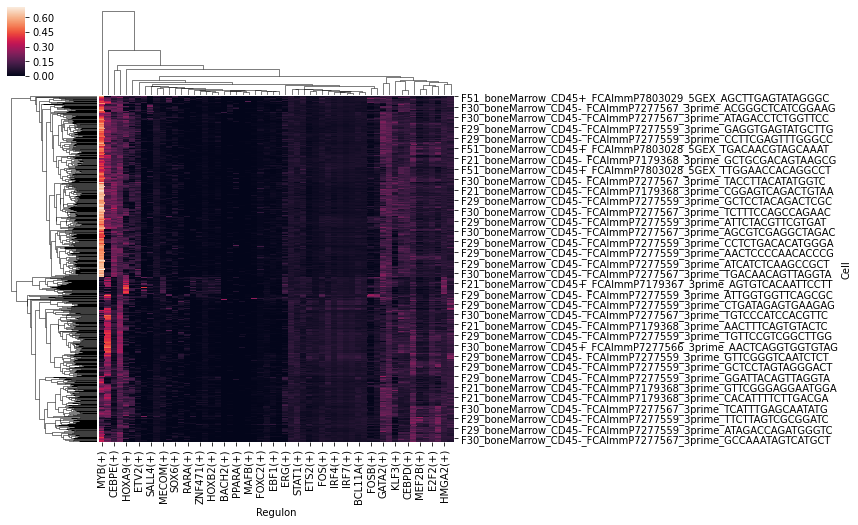

In [26]:
auc_mtx = aucell(ex_matrix, regulons, num_workers=4)
sns.clustermap(auc_mtx, figsize=(8,8))

In [27]:
HSC.obs = pd.concat([HSC.obs, auc_mtx], axis=1, join='inner')

In [28]:
HSC.obsm

AxisArrays with keys: X_draw_graph_fa, X_harmony, X_diffmap

In [29]:
TFs = list(auc_mtx.columns) 

In [30]:
paths = [('HSC', ['HSC', 'CMP', 'GMP', 'myeloid DC progenitor', 'DC precursor']),
        ('HSC2', ['HSC', 'CMP', 'GMP', 'myeloid DC progenitor', 'DC precursor'])]

In [31]:
HSC.obs['distance'] = HSC.obs['dpt_pseudotime']
HSC.obs['clusters'] = HSC.obs['cell.labels']


In [32]:
gene_names = TFs


In [33]:
gene_names

['ATF5(+)',
 'BACH2(+)',
 'BCL11A(+)',
 'BHLHE40(+)',
 'CDX1(+)',
 'CEBPB(+)',
 'CEBPD(+)',
 'CEBPE(+)',
 'E2F2(+)',
 'E2F8(+)',
 'EBF1(+)',
 'EGR1(+)',
 'ERG(+)',
 'ETS1(+)',
 'ETS2(+)',
 'ETV2(+)',
 'FOS(+)',
 'FOSB(+)',
 'FOXC2(+)',
 'GATA1(+)',
 'GATA2(+)',
 'HIVEP1(+)',
 'HMGA2(+)',
 'HOXA9(+)',
 'HOXB2(+)',
 'HOXB5(+)',
 'IRF1(+)',
 'IRF4(+)',
 'IRF7(+)',
 'IRF8(+)',
 'JUN(+)',
 'JUNB(+)',
 'KLF12(+)',
 'KLF3(+)',
 'KLF4(+)',
 'LEF1(+)',
 'MAFB(+)',
 'MECOM(+)',
 'MEF2B(+)',
 'MYB(+)',
 'MYBL2(+)',
 'MYC(+)',
 'PAX5(+)',
 'PBX3(+)',
 'POU2AF1(+)',
 'POU2F2(+)',
 'PPARA(+)',
 'PRDM1(+)',
 'RARA(+)',
 'RUNX2(+)',
 'SALL4(+)',
 'SIX5(+)',
 'SOX6(+)',
 'SPIB(+)',
 'STAT1(+)',
 'TCF4(+)',
 'ZEB1(+)',
 'ZNF471(+)']

/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/scanpy/_utils.py:415: RuntimeWarning: invalid value encountered in subtract
  ret[n:] = ret[n:] - ret[:-n]
/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/scanpy/_utils.py:415: RuntimeWarning: invalid value encountered in subtract
  ret[n:] = ret[n:] - ret[:-n]


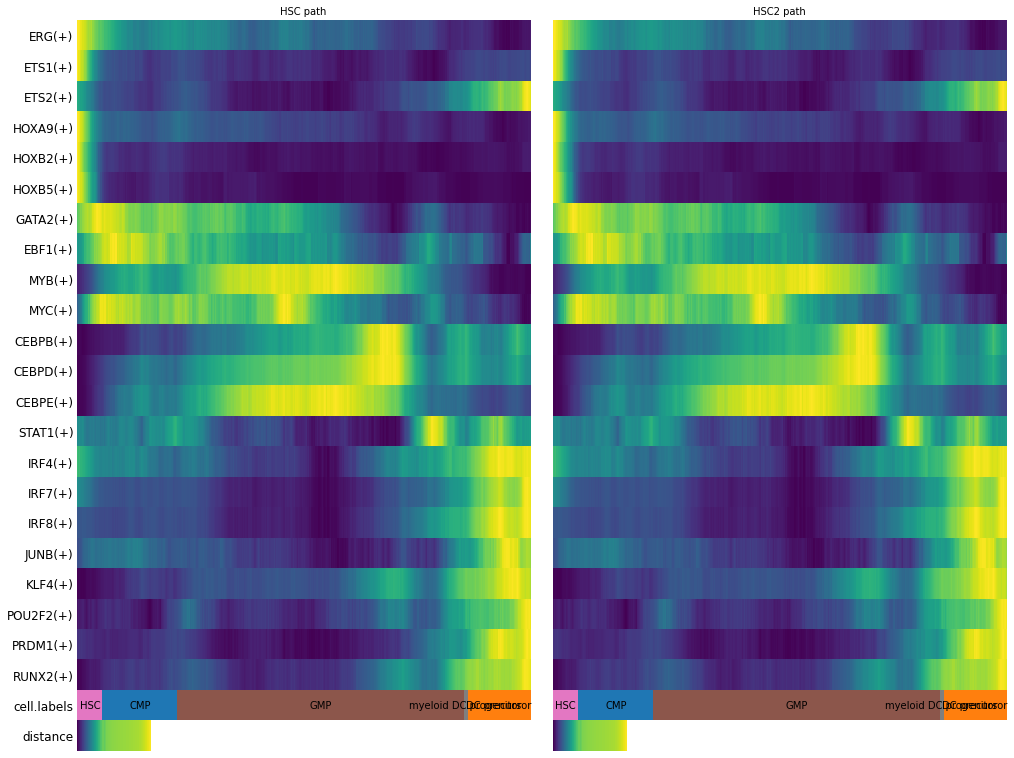

In [39]:
_, axs = plt.subplots(ncols=2, figsize=(15, 15), gridspec_kw={'wspace': 0.05, 'left': 0.12})
plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        HSC, path, gene_names,
        show_node_names=True,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='viridis',
        groups_key='cell.labels',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        normalize_to_zero_one = True,
        show=False)
    plt.savefig('./figures/HSC_path.pdf')

In [38]:
gene_names = [
    
    #HSC
'ERG(+)',
 'ETS1(+)',
 'ETS2(+)', 
 'HOXA9(+)',
 'HOXB2(+)',
 'HOXB5(+)',   
    
    ###CMP
    'GATA2(+)',
    'EBF1(+)',
    
    ###GMP
   
    'MYB(+)',
    'MYC(+)',
    'CEBPB(+)',
 'CEBPD(+)',
 'CEBPE(+)',
    
    ###myeloid DC precursor  
   
    'STAT1(+)',
    
    ###DCs
 'IRF4(+)',
 'IRF7(+)',
 'IRF8(+)',
  'JUNB(+)',  
    'KLF4(+)',
    'POU2F2(+)',
    'PRDM1(+)',
 'RUNX2(+)',
  ]  
 



***DC precursor to paths***


In [267]:
os.chdir('/home/ngr18/bone_marrow')
bm = sc.read_h5ad('HSC_to_DC.h5ad')

In [321]:
DC = bm[bm.obs['cell.labels'].isin(['DC precursor', 'tDC', 'DC1', 'DC2', 'DC3', 'pDC'])]

In [322]:
sc.pp.neighbors(DC, n_neighbors=10, n_pcs=30, use_rep="X_harmony")

In [323]:
sc.tl.paga(DC, groups='cell.labels', neighbors_key = 'harmony')

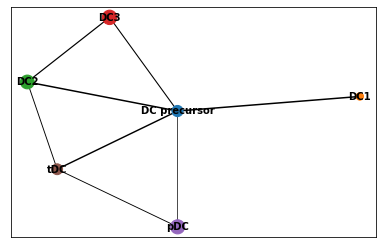

In [325]:
sc.pl.paga(DC, color=['cell.labels'], threshold = 0.4, edge_width_scale = 0.2, fontsize = 10, 
           save = 'DC_precursor_paths.pdf')

In [347]:
DC.uns['iroot'] = np.flatnonzero(DC.obs['cell.labels']  == 'DC precursor')[0]

In [326]:
sc.tl.diffmap(DC, neighbors_key='harmony')

In [349]:
sc.tl.dpt(DC, neighbors_key = 'harmony')

In [328]:
ex_matrix = pd.DataFrame(DC.X.toarray())
ex_matrix.columns = DC.var.index
ex_matrix.index = DC.obs.index

In [329]:
ex_matrix.shape

(995, 3000)

In [330]:
tf_names = load_tf_names(MM_TFS_FNAME)

In [331]:
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr")]

In [332]:
adjacencies = grnboost2(ex_matrix, tf_names=tf_names, verbose=True)

preparing dask client
parsing input
creating dask graph


/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/arboreto/algo.py:214: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  expression_matrix = expression_data.as_matrix()


5 partitions
computing dask graph
shutting down client and local cluster
finished


In [333]:
modules = list(modules_from_adjacencies(adjacencies, ex_matrix))


2020-06-14 16:58:37,548 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-06-14 16:58:37,550 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-06-14 16:58:42,640 - pyscenic.utils - INFO - Creating modules.


In [334]:
with ProgressBar():
    df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

[                                        ] | 0% Completed |  6.9s


2020-06-14 16:59:20,447 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BACH2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  9.4s


2020-06-14 16:59:22,950 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  9.6s


2020-06-14 16:59:23,188 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BACH2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 12.9s


2020-06-14 16:59:26,528 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for L3MBTL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 13.3s


2020-06-14 16:59:26,857 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 13.4s


2020-06-14 16:59:26,972 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LCOR could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 15.9s


2020-06-14 16:59:29,474 - pyscenic.transform - WARNING - Less than 80% of the genes in AKNA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 16.4s


2020-06-14 16:59:29,883 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 16.8s


2020-06-14 16:59:30,314 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 16.9s


2020-06-14 16:59:30,508 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 17.3s


2020-06-14 16:59:30,842 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 17.6s


2020-06-14 16:59:31,123 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 18.8s


2020-06-14 16:59:32,380 - pyscenic.transform - WARNING - Less than 80% of the genes in SETBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 19.2s


2020-06-14 16:59:32,719 - pyscenic.transform - WARNING - Less than 80% of the genes in SKIL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 19.4s


2020-06-14 16:59:32,943 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 19.8s


2020-06-14 16:59:33,259 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 20.0s


2020-06-14 16:59:33,609 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 20.3s


2020-06-14 16:59:33,785 - pyscenic.transform - WARNING - Less than 80% of the genes in SP110 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 20.4s


2020-06-14 16:59:33,984 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFDP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 21.7s


2020-06-14 16:59:35,222 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for USF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 21.9s


2020-06-14 16:59:35,434 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB16 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 23.0s


2020-06-14 16:59:36,572 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE40 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 25.2s


2020-06-14 16:59:38,643 - pyscenic.transform - WARNING - Less than 80% of the genes in JAZF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 26.5s


2020-06-14 16:59:40,020 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 26.8s


2020-06-14 16:59:40,263 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX19 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 30.4s


2020-06-14 16:59:43,921 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM5B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 30.9s


2020-06-14 16:59:44,474 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF395 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[                                        ] | 0% Completed | 31.0s

[                                        ] | 0% Completed | 31.5s


2020-06-14 16:59:44,991 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB16 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 32.0s


2020-06-14 16:59:45,609 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[                                        ] | 0% Completed | 32.1s



2020-06-14 16:59:45,681 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 32.8s


2020-06-14 16:59:46,300 - pyscenic.transform - WARNING - Less than 80% of the genes in TSC22D1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[##                                      ] | 5% Completed | 32.9s



2020-06-14 16:59:46,327 - pyscenic.transform - WARNING - Less than 80% of the genes in CSRNP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 33.6s


2020-06-14 16:59:47,121 - pyscenic.transform - WARNING - Less than 80% of the genes in CUX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 33.9s


2020-06-14 16:59:47,437 - pyscenic.transform - WARNING - Less than 80% of the genes in USF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed | 34.0s

[####                                    ] | 10% Completed | 34.1s


2020-06-14 16:59:47,575 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB16 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-14 16:59:47,583 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF385C could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 34.6s


2020-06-14 16:59:48,060 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF397 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 34.7s


2020-06-14 16:59:48,206 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 35.8s


2020-06-14 16:59:49,307 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 36.1s


2020-06-14 16:59:49,617 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF10 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 36.2s


2020-06-14 16:59:49,706 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF415 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 36.4s


2020-06-14 16:59:49,936 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 36.7s


2020-06-14 16:59:50,252 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF175 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed | 36.8s

[####                                    ] | 10% Completed | 37.1s


2020-06-14 16:59:50,623 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF235 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 37.2s


2020-06-14 16:59:50,740 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 37.4s


2020-06-14 16:59:50,943 - pyscenic.transform - WARNING - Less than 80% of the genes in LCOR could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 37.5s


2020-06-14 16:59:50,962 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF296 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 38.3s


2020-06-14 16:59:51,806 - pyscenic.transform - WARNING - Less than 80% of the genes in LYL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-14 16:59:51,833 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF385C could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 38.5s


2020-06-14 16:59:52,038 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF395 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 38.9s


2020-06-14 16:59:52,386 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 39.1s


2020-06-14 16:59:52,676 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF415 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed | 39.2s

[####                                    ] | 10% Completed | 39.4s


2020-06-14 16:59:52,989 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 39.5s


2020-06-14 16:59:53,003 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF43 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 39.9s


2020-06-14 16:59:53,401 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF449 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 40.0s


2020-06-14 16:59:53,555 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF449 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-14 16:59:53,575 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF454 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 40.3s


2020-06-14 16:59:53,836 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF467 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 40.8s


2020-06-14 16:59:54,358 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF490 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 41.1s


2020-06-14 16:59:54,630 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF521 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 42.3s


2020-06-14 16:59:55,801 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BACH2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 43.0s


2020-06-14 16:59:56,515 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 43.1s


2020-06-14 16:59:56,559 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF713 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-14 16:59:56,614 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 43.8s


2020-06-14 16:59:57,337 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF791 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 44.2s


2020-06-14 16:59:57,683 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF836 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 44.8s


2020-06-14 16:59:58,335 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed | 44.9s

[####                                    ] | 10% Completed | 45.4s


2020-06-14 16:59:58,868 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN20 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 45.6s


2020-06-14 16:59:59,110 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF880 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 45.9s


2020-06-14 16:59:59,427 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN20 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 46.1s


2020-06-14 16:59:59,621 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 46.2s


2020-06-14 16:59:59,716 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-14 16:59:59,753 - pyscenic.transform - WARNING - Less than 80% of the genes in AKNA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed | 46.3s

[####                                    ] | 10% Completed | 47.3s


2020-06-14 17:00:00,786 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 47.9s


2020-06-14 17:00:01,390 - pyscenic.transform - WARNING - Less than 80% of the genes in AR could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 48.2s


2020-06-14 17:00:01,727 - pyscenic.transform - WARNING - Less than 80% of the genes in MYC could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 48.5s


2020-06-14 17:00:01,968 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-14 17:00:02,034 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 48.8s


2020-06-14 17:00:02,305 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 49.0s


2020-06-14 17:00:02,508 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-14 17:00:02,549 - pyscenic.transform - WARNING - Less than 80% of the genes in NFX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 49.3s


2020-06-14 17:00:02,795 - pyscenic.transform - WARNING - Less than 80% of the genes in NFXL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 50.0s


2020-06-14 17:00:03,506 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 50.4s


2020-06-14 17:00:03,914 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 50.7s


2020-06-14 17:00:04,221 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 52.0s


2020-06-14 17:00:05,586 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 54.3s


2020-06-14 17:00:07,770 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 54.4s


2020-06-14 17:00:07,884 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 54.5s


2020-06-14 17:00:08,005 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 54.9s


2020-06-14 17:00:08,416 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2AF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-14 17:00:08,445 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE40 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed | 55.0s

[####                                    ] | 10% Completed | 55.3s


2020-06-14 17:00:08,795 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 56.7s


2020-06-14 17:00:10,250 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 57.2s


2020-06-14 17:00:10,731 - pyscenic.transform - WARNING - Less than 80% of the genes in RAG1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 57.5s


2020-06-14 17:00:11,057 - pyscenic.transform - WARNING - Less than 80% of the genes in RARA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed | 57.6s

[####                                    ] | 10% Completed | 57.7s


2020-06-14 17:00:11,229 - pyscenic.transform - WARNING - Less than 80% of the genes in RORC could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 59.5s


2020-06-14 17:00:13,018 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 59.7s


2020-06-14 17:00:13,280 - pyscenic.transform - WARNING - Less than 80% of the genes in SETBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  0.0s


2020-06-14 17:00:13,533 - pyscenic.transform - WARNING - Less than 80% of the genes in SKIL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  0.5s


2020-06-14 17:00:14,073 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  1.1s


2020-06-14 17:00:14,653 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GFI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-14 17:00:14,664 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  1.4s


2020-06-14 17:00:14,961 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  1.9s


2020-06-14 17:00:15,416 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  2.2s


2020-06-14 17:00:15,716 - pyscenic.transform - WARNING - Less than 80% of the genes in SP110 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  4.2s


2020-06-14 17:00:17,634 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SKIL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  4.9s


2020-06-14 17:00:18,341 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  5.8s


2020-06-14 17:00:19,300 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSFX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  5.9s


2020-06-14 17:00:19,406 - pyscenic.transform - WARNING - Less than 80% of the genes in CSRNP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  6.1s


2020-06-14 17:00:19,572 - pyscenic.transform - WARNING - Less than 80% of the genes in CSRNP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  6.4s


2020-06-14 17:00:19,862 - pyscenic.transform - WARNING - Less than 80% of the genes in CUX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  6.6s


2020-06-14 17:00:20,106 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  6.9s


2020-06-14 17:00:20,451 - pyscenic.transform - WARNING - Less than 80% of the genes in DACH1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-14 17:00:20,454 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX19 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 10.1s


2020-06-14 17:00:23,640 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 10.7s


2020-06-14 17:00:24,288 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 11.0s


2020-06-14 17:00:24,559 - pyscenic.transform - WARNING - Less than 80% of the genes in TSC22D1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 11.1s


2020-06-14 17:00:24,661 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 11.4s


2020-06-14 17:00:24,934 - pyscenic.transform - WARNING - Less than 80% of the genes in USF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 11.5s


2020-06-14 17:00:25,081 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB16 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 11.7s


2020-06-14 17:00:25,250 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 12.2s


2020-06-14 17:00:25,760 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA9 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 12.6s


2020-06-14 17:00:26,170 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 12.9s


2020-06-14 17:00:26,446 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 13.5s


2020-06-14 17:00:27,040 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 13.9s


2020-06-14 17:00:27,396 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 14.0s


2020-06-14 17:00:27,461 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 14.2s


2020-06-14 17:00:27,684 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF10 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 14.5s


2020-06-14 17:00:27,920 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 14.7s


2020-06-14 17:00:28,227 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF235 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 15.0s


2020-06-14 17:00:28,491 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF296 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 15.7s


2020-06-14 17:00:29,150 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF385C could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 15.8s


2020-06-14 17:00:29,277 - pyscenic.transform - WARNING - Less than 80% of the genes in ERG could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-14 17:00:29,323 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF395 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 16.0s


2020-06-14 17:00:29,543 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed |  1min 16.1s



2020-06-14 17:00:29,600 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 16.3s


2020-06-14 17:00:29,702 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF415 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 16.7s


2020-06-14 17:00:30,229 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF449 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 16.8s


2020-06-14 17:00:30,287 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-14 17:00:30,332 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF454 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 17.4s


2020-06-14 17:00:30,903 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF471 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 17.5s


2020-06-14 17:00:31,027 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF490 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 17.7s


2020-06-14 17:00:31,184 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF521 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 17.9s


2020-06-14 17:00:31,411 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF556 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 18.0s


2020-06-14 17:00:31,551 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF713 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed |  1min 18.1s

[####                                    ] | 10% Completed |  1min 18.7s


2020-06-14 17:00:32,191 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF791 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 18.9s


2020-06-14 17:00:32,391 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF836 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 19.3s


2020-06-14 17:00:32,830 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 19.8s


2020-06-14 17:00:33,336 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN20 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  1min 20.8s


2020-06-14 17:00:34,392 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF385C could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  1min 21.3s


2020-06-14 17:00:34,806 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF397 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  1min 21.4s


2020-06-14 17:00:34,962 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF415 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  1min 24.2s


2020-06-14 17:00:37,744 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  1min 26.7s


2020-06-14 17:00:40,304 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  1min 26.8s


2020-06-14 17:00:40,361 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN20 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  1min 29.5s


2020-06-14 17:00:43,020 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM5B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[########                                ] | 20% Completed |  1min 29.6s

[########                                ] | 20% Completed |  1min 29.8s


2020-06-14 17:00:43,295 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  1min 33.6s


2020-06-14 17:00:47,101 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GFI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  1min 34.8s


2020-06-14 17:00:48,336 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  1min 35.1s


2020-06-14 17:00:48,672 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  1min 36.4s


2020-06-14 17:00:49,900 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.
2020-06-14 17:00:49,908 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA9 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  1min 36.5s

[############                            ] | 30% Completed |  1min 36.7s


2020-06-14 17:00:50,216 - pyscenic.transform - WARNING - Less than 80% of the genes in LCOR could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-14 17:00:50,219 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  1min 37.6s


2020-06-14 17:00:51,080 - pyscenic.transform - WARNING - Less than 80% of the genes in LYL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  1min 40.4s


2020-06-14 17:00:53,980 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEIS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  1min 41.8s


2020-06-14 17:00:55,398 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  1min 43.3s


2020-06-14 17:00:56,774 - pyscenic.transform - WARNING - Less than 80% of the genes in MYC could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  1min 47.0s


2020-06-14 17:01:00,522 - pyscenic.transform - WARNING - Less than 80% of the genes in NFX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  1min 47.3s


2020-06-14 17:01:00,800 - pyscenic.transform - WARNING - Less than 80% of the genes in NFXL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  1min 48.6s


2020-06-14 17:01:02,133 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  1min 54.9s


2020-06-14 17:01:08,421 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  1min 55.1s


2020-06-14 17:01:08,673 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  1min 56.4s


2020-06-14 17:01:09,974 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####################                    ] | 50% Completed |  1min 56.5s

[####################                    ] | 50% Completed |  1min 56.9s


2020-06-14 17:01:10,450 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2AF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  1min 57.1s


2020-06-14 17:01:10,676 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  1min 57.3s


2020-06-14 17:01:10,879 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  2min  0.2s


2020-06-14 17:01:13,637 - pyscenic.transform - WARNING - Less than 80% of the genes in RAG1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  2min  0.4s


2020-06-14 17:01:13,814 - pyscenic.transform - WARNING - Less than 80% of the genes in RARA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  2min  1.0s


2020-06-14 17:01:14,509 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########################################] | 100% Completed |  2min  9.5s


In [335]:
regulons = df2regulons(df)

In [336]:
df.to_csv(MOTIFS_FNAME)
with open(REGULONS_FNAME, "wb") as f:
    pickle.dump(regulons, f)

In [337]:
SCHEDULER="127.0.0.1:12345"

In [338]:
df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)


2020-06-14 17:01:36,415 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BACH2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-14 17:01:38,298 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-14 17:01:38,304 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BACH2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-14 17:01:41,466 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-14 17:01:42,159 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for L3MBTL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-14

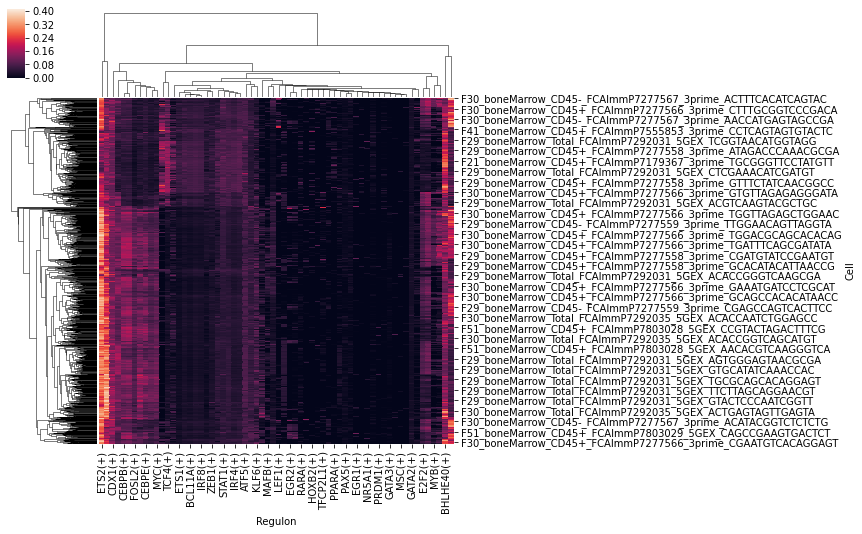

In [339]:
auc_mtx = aucell(ex_matrix, regulons, num_workers=4)
sns.clustermap(auc_mtx, figsize=(8,8))

In [340]:
DC.obs = pd.concat([DC.obs, auc_mtx], axis=1, join='inner')

In [341]:
DC.uns['iroot'] = np.flatnonzero(DC.obs['cell.labels']  == 'DC precursor')[0]

In [343]:
TFs = list(auc_mtx.columns) 

In [344]:
paths = [('DC1', ['DC precursor','DC1']),
         ('DC2', ['DC precursor', 'DC2']),
         ('DC3', ['DC precursor', 'DC3']),
         ('pDC', ['DC precursor', 'pDC']),
        ('tDC', ['DC precursor', 'tDC']),]

In [350]:
DC.obs['distance'] = DC.obs['dpt_pseudotime']
DC.obs['clusters'] = DC.obs['cell.labels']


In [351]:
gene_names = TFs

/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/scanpy/_utils.py:415: RuntimeWarning: invalid value encountered in subtract
  ret[n:] = ret[n:] - ret[:-n]
/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order

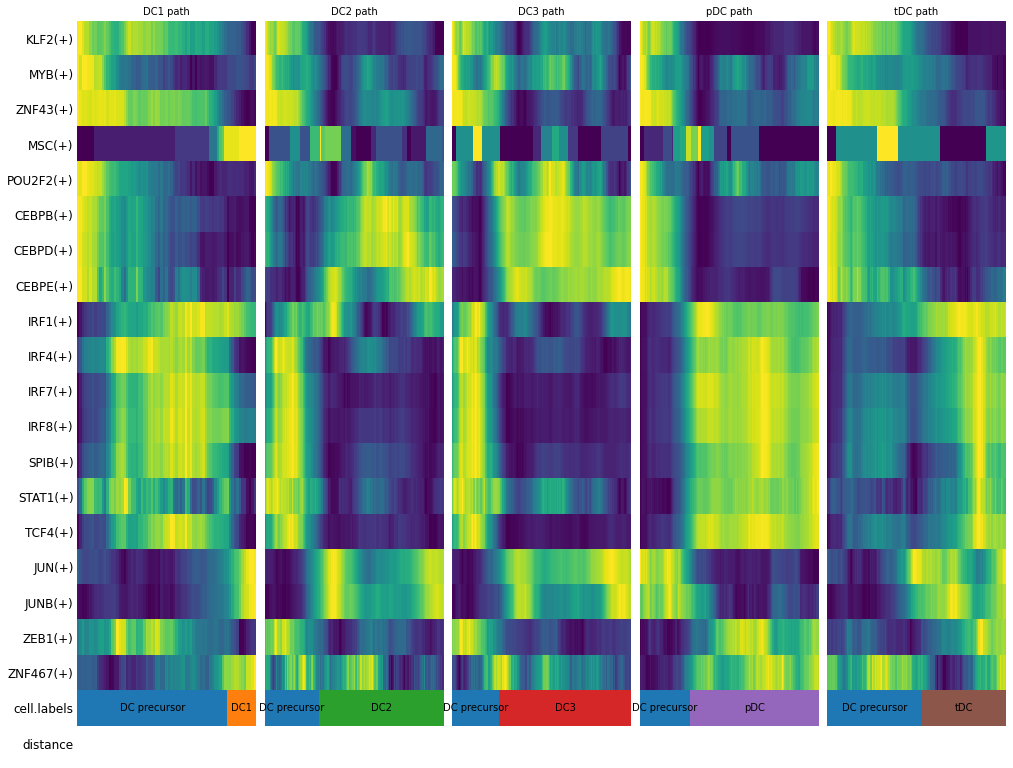

In [375]:
_, axs = plt.subplots(ncols=5, figsize=(15, 15), gridspec_kw={'wspace': 0.05, 'left': 0.12})
plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        DC, path, gene_names,
        show_node_names=True,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='viridis',
        groups_key='cell.labels',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True, normalize_to_zero_one = True, 
        show=False)
    
plt.savefig('./figures/DC_precursor_paths.pdf')

In [358]:
gene_names = [
    ###DC precursor
    'KLF2(+)', 'MYB(+)', 'ZNF43(+)',
###DC1
'MSC(+)','POU2F2(+)',

###DC2/3
'CEBPB(+)',
'CEBPD(+)',
'CEBPE(+)',

##pDC
'IRF1(+)',
'IRF4(+)', 'IRF7(+)','IRF8(+)',
'SPIB(+)',
'STAT1(+)','TCF4(+)',

###tDC
'JUN(+)',
'JUNB(+)',
'ZEB1(+)','ZNF467(+)']

In [378]:
aucell_adata = sc.AnnData(X=auc_mtx.sort_index())
aucell_adata.obs = DC.obs



***pDC pathway***



In [87]:
###Import data from Seurat
pDC=io.mmread('pDC.mtx')
pDC=pDC.tocsr()
genes=pd.read_csv('pDC_genes.csv', index_col =1)
meta=pd.read_csv("pDC_meta.csv", index_col = 0)
pDC=anndata.AnnData(X=pDC.T, obs=meta, var=genes)
pDC.obs.seurat_clusters = pDC.obs.seurat_clusters.astype('category')

In [88]:
sc.pp.normalize_total(pDC, target_sum=1e4)
sc.pp.log1p(pDC)

In [89]:
sc.pp.highly_variable_genes(pDC, n_top_genes = 3000)

In [90]:
pDC = pDC[:, pDC.var.highly_variable]

In [91]:
sc.pp.scale(pDC, max_value=10)

/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [92]:
print(sc.__version__)

1.5.1


In [93]:
sc.tl.pca(bm, svd_solver='arpack')

In [94]:
embed = pd.read_csv('embed_pDC.csv', index_col = 0)
embed = np.array(embed)
pDC.obsm['X_harmony'] = embed

In [95]:
sc.pp.neighbors(pDC, n_neighbors=10, n_pcs=30, use_rep="X_harmony", key_added='harmony', method = 'gauss')
sc.tl.louvain(pDC, resolution=0.6, neighbors_key = 'harmony')

In [96]:
sc.tl.paga(pDC, groups='cell.labels', neighbors_key = 'harmony')

... storing 'orig.ident' as categorical
... storing 'cell.labels' as categorical
... storing 'doublets' as categorical
... storing 'fetal.ids' as categorical
... storing 'gender' as categorical
... storing 'lanes' as categorical
... storing 'processing.type' as categorical
... storing 'sequencing.type' as categorical
... storing 'sort.ids' as categorical
... storing 'april_cell.labels' as categorical


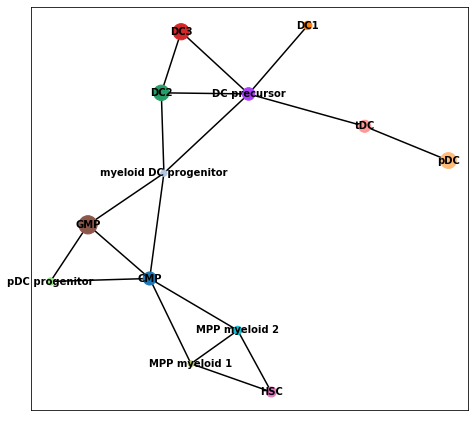

In [97]:
sc.pl.paga(pDC, color=['cell.labels'], threshold = 1.0, edge_width_scale = 0.2, fontsize = 10)



***Calculate HSC path***



In [148]:
HSC = pDC[pDC.obs['cell.labels'].isin(['pDC progenitor','HSC', 'CMP', 'GMP', 'myeloid DC progenitor',
                                      'DC precursor', 'MPP myeloid 1', 'MPP myeloid 2'])]

In [149]:
HSC.uns['iroot'] = np.flatnonzero(HSC.obs['cell.labels']  == 'HSC')[0]

Trying to set attribute `.uns` of view, copying.


In [150]:
sc.pp.neighbors(HSC, n_neighbors=10, n_pcs=30, use_rep="X_harmony", key_added='harmony')

In [151]:
del HSC.obsm['X_diffmap']

In [152]:
sc.tl.diffmap(HSC, neighbors_key = 'harmony')


In [153]:
sc.tl.dpt(HSC, neighbors_key = 'harmony')



In [155]:
sc.tl.paga(HSC, groups='cell.labels', neighbors_key = 'harmony')

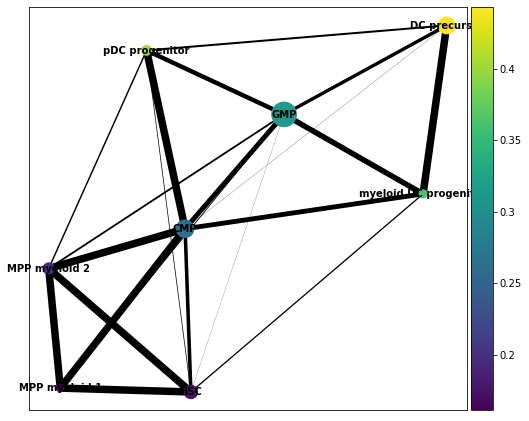

In [156]:
sc.pl.paga(HSC, color=['dpt_pseudotime'])

In [158]:
ex_matrix = pd.DataFrame(HSC.X.toarray())
ex_matrix.columns = HSC.var.index
ex_matrix.index = HSC.obs.index

In [159]:
ex_matrix.shape

(768, 3000)

In [160]:
tf_names = load_tf_names(MM_TFS_FNAME)

In [161]:
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr")]

In [162]:
adjacencies = grnboost2(ex_matrix, tf_names=tf_names, verbose=True)

preparing dask client
parsing input
creating dask graph


/home/ngr18/anaconda3/envs/hcaskin2/lib/python3.6/site-packages/arboreto/algo.py:214: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  expression_matrix = expression_data.as_matrix()


5 partitions
computing dask graph
shutting down client and local cluster
finished


In [163]:
modules = list(modules_from_adjacencies(adjacencies, ex_matrix))


2020-06-10 19:19:10,835 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-06-10 19:19:10,836 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-06-10 19:19:16,279 - pyscenic.utils - INFO - Creating modules.


In [164]:
with ProgressBar():
    df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

[                                        ] | 0% Completed | 13.4s


2020-06-10 19:19:59,012 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[                                        ] | 0% Completed | 13.5s

[                                        ] | 0% Completed | 14.1s


2020-06-10 19:19:59,670 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 17.0s


2020-06-10 19:20:02,564 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF471 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 18.3s


2020-06-10 19:20:03,961 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF791 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 18.8s


2020-06-10 19:20:04,371 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 19.0s


2020-06-10 19:20:04,563 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 19.2s


2020-06-10 19:20:04,756 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF98 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 19.3s


2020-06-10 19:20:04,964 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN20 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[                                        ] | 0% Completed | 19.4s

[                                        ] | 0% Completed | 19.5s


2020-06-10 19:20:05,172 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX3-1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 19.8s


2020-06-10 19:20:05,466 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 20.4s


2020-06-10 19:20:05,993 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[                                        ] | 0% Completed | 20.5s

[                                        ] | 0% Completed | 20.7s


2020-06-10 19:20:06,294 - pyscenic.transform - WARNING - Less than 80% of the genes in AR could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 21.3s


2020-06-10 19:20:06,840 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 21.7s


2020-06-10 19:20:07,384 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 23.0s


2020-06-10 19:20:08,682 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[                                        ] | 0% Completed | 23.1s

[                                        ] | 0% Completed | 23.7s


2020-06-10 19:20:09,388 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXC2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[                                        ] | 0% Completed | 23.8s

[                                        ] | 0% Completed | 32.5s


2020-06-10 19:20:18,129 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 34.0s


2020-06-10 19:20:19,530 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 41.9s


2020-06-10 19:20:27,526 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 44.7s


2020-06-10 19:20:30,311 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 53.4s


2020-06-10 19:20:39,019 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF556 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 54.7s


2020-06-10 19:20:40,233 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 55.9s


2020-06-10 19:20:41,484 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 56.4s


2020-06-10 19:20:42,005 - pyscenic.transform - WARNING - Less than 80% of the genes in SKIL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 58.6s


2020-06-10 19:20:44,176 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF556 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 59.8s


2020-06-10 19:20:45,418 - pyscenic.transform - WARNING - Less than 80% of the genes in JUN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  1.8s


2020-06-10 19:20:47,409 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed |  1min  1.9s

[####                                    ] | 10% Completed |  1min  2.2s


2020-06-10 19:20:47,751 - pyscenic.transform - WARNING - Less than 80% of the genes in AKNA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  2.4s


2020-06-10 19:20:48,027 - pyscenic.transform - WARNING - Less than 80% of the genes in AR could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed |  1min  2.5s

[####                                    ] | 10% Completed |  1min  2.8s


2020-06-10 19:20:48,326 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  3.0s


2020-06-10 19:20:48,593 - pyscenic.transform - WARNING - Less than 80% of the genes in SP110 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  4.0s


2020-06-10 19:20:49,637 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  6.2s


2020-06-10 19:20:51,742 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  6.5s


2020-06-10 19:20:52,064 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  6.9s


2020-06-10 19:20:52,497 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  7.9s


2020-06-10 19:20:53,517 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  8.2s


2020-06-10 19:20:53,815 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min  9.6s


2020-06-10 19:20:55,230 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 10.1s


2020-06-10 19:20:55,788 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX19 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed |  1min 10.2s

[####                                    ] | 10% Completed |  1min 10.7s


2020-06-10 19:20:56,313 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 11.7s


2020-06-10 19:20:57,344 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 12.7s


2020-06-10 19:20:58,218 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 13.8s


2020-06-10 19:20:59,402 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB16 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 18.7s


2020-06-10 19:21:04,302 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFPM1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed |  1min 18.8s

[####                                    ] | 10% Completed |  1min 20.0s


2020-06-10 19:21:05,577 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 20.4s


2020-06-10 19:21:05,959 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 20.8s


2020-06-10 19:21:06,338 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 21.8s


2020-06-10 19:21:07,421 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF235 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 23.2s


2020-06-10 19:21:08,796 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 23.6s


2020-06-10 19:21:09,237 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 24.1s


2020-06-10 19:21:09,775 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF43 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed |  1min 24.2s

[####                                    ] | 10% Completed |  1min 25.4s


2020-06-10 19:21:11,034 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF471 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 26.2s


2020-06-10 19:21:11,860 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF521 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 26.5s


2020-06-10 19:21:12,025 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF556 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 26.8s


2020-06-10 19:21:12,380 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed |  1min 26.9s

[####                                    ] | 10% Completed |  1min 28.1s


2020-06-10 19:21:13,675 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 28.4s


2020-06-10 19:21:13,974 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF98 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 28.6s


2020-06-10 19:21:14,234 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 31.1s


2020-06-10 19:21:16,792 - pyscenic.transform - WARNING - Less than 80% of the genes in CSRNP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed |  1min 31.3s

[####                                    ] | 10% Completed |  1min 32.0s


2020-06-10 19:21:17,619 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 32.2s


2020-06-10 19:21:17,744 - pyscenic.transform - WARNING - Less than 80% of the genes in DACH1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 34.5s


2020-06-10 19:21:20,153 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed |  1min 34.6s

[####                                    ] | 10% Completed |  1min 35.2s


2020-06-10 19:21:20,806 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 37.7s


2020-06-10 19:21:23,325 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 39.6s


2020-06-10 19:21:25,254 - pyscenic.transform - WARNING - Less than 80% of the genes in NFXL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 39.9s


2020-06-10 19:21:25,505 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX3-1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 47.0s


2020-06-10 19:21:32,600 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 48.3s


2020-06-10 19:21:33,996 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[####                                    ] | 10% Completed |  1min 48.4s

[####                                    ] | 10% Completed |  1min 52.3s


2020-06-10 19:21:37,917 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  1min 54.7s


2020-06-10 19:21:40,368 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  1min 55.2s


2020-06-10 19:21:40,803 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[########                                ] | 20% Completed |  1min 55.3s

[########                                ] | 20% Completed |  1min 57.2s


2020-06-10 19:21:42,815 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[########                                ] | 20% Completed |  1min 57.3s

[########                                ] | 20% Completed |  1min 59.8s


2020-06-10 19:21:45,397 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min  6.3s


2020-06-10 19:21:51,953 - pyscenic.transform - WARNING - Less than 80% of the genes in SKIL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[########                                ] | 20% Completed |  2min  6.4s

[########                                ] | 20% Completed |  2min  6.7s


2020-06-10 19:21:52,367 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[########                                ] | 20% Completed |  2min  6.8s

[########                                ] | 20% Completed |  2min 13.7s


2020-06-10 19:21:59,266 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 14.2s


2020-06-10 19:21:59,859 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX19 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

[########                                ] | 20% Completed |  2min 14.3s

[########                                ] | 20% Completed |  2min 15.0s


2020-06-10 19:22:00,596 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 15.3s


2020-06-10 19:22:00,917 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  2min 16.7s


2020-06-10 19:22:02,362 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB16 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  2min 21.6s


2020-06-10 19:22:07,273 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFPM1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  2min 21.8s


2020-06-10 19:22:07,388 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFPM2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  2min 22.9s


2020-06-10 19:22:08,563 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  2min 23.4s


2020-06-10 19:22:08,995 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF235 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  2min 24.2s


2020-06-10 19:22:09,841 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF395 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  2min 24.5s


2020-06-10 19:22:10,127 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  2min 25.0s


2020-06-10 19:22:10,581 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF43 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  2min 38.2s


2020-06-10 19:22:23,751 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  2min 39.7s


2020-06-10 19:22:25,326 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############################            ] | 70% Completed |  2min 43.9s


2020-06-10 19:22:29,489 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  2min 54.7s


2020-06-10 19:22:40,329 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  2min 55.2s


2020-06-10 19:22:40,916 - pyscenic.transform - WARNING - Less than 80% of the genes in NFX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  2min 55.5s


2020-06-10 19:22:41,214 - pyscenic.transform - WARNING - Less than 80% of the genes in NFXL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########################################] | 100% Completed |  3min  7.7s


In [165]:
regulons = df2regulons(df)

In [166]:
df.to_csv(MOTIFS_FNAME)
with open(REGULONS_FNAME, "wb") as f:
    pickle.dump(regulons, f)

In [167]:
SCHEDULER="127.0.0.1:12345"

In [168]:
df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)


2020-06-10 19:23:12,298 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-10 19:23:12,943 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-10 19:23:15,734 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF471 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-10 19:23:17,365 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF791 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-10 19:23:17,730 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2020-06-10 19:23:18,105 - pyscenic.transform - 

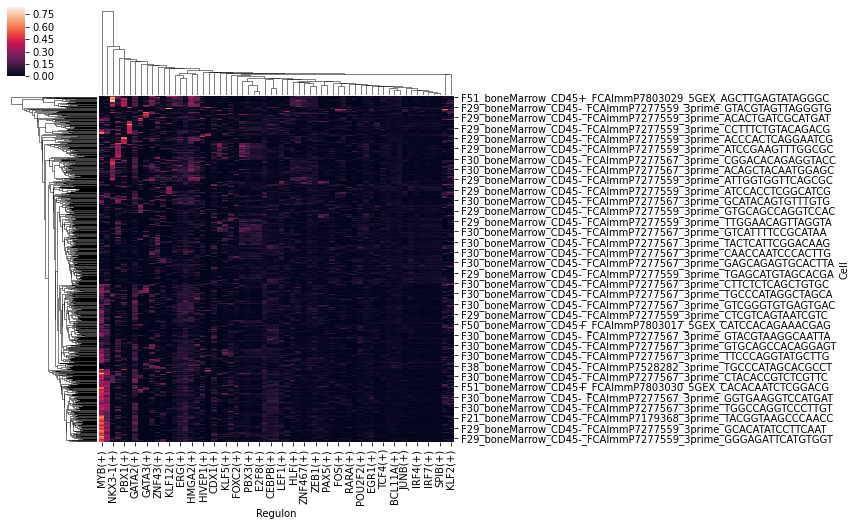

In [170]:
auc_mtx = aucell(ex_matrix, regulons, num_workers=4)
sns.clustermap(auc_mtx, figsize=(8,8))

In [171]:
HSC.obs = pd.concat([HSC.obs, auc_mtx], axis=1, join='inner')

In [172]:
TFs = list(auc_mtx.columns) 

In [173]:
HSC.obs['distance'] = HSC.obs['dpt_pseudotime']
HSC.obs['clusters'] = HSC.obs['cell.labels']


In [186]:
paths = [('HSC', ['HSC', 'MPP myeloid 1', 'MPP myeloid 2', 'CMP', 'GMP', 'myeloid DC progenitor',
                                      'DC precursor' ]),
       ('asd', ['HSC', 'MPP myeloid 1', 'MPP myeloid 2', 'CMP', 'GMP', 'myeloid DC progenitor',
                                      'DC precursor' ])]

In [178]:
HSC.obs['cell.labels'] = HSC.obs['cell.labels'].astype('category')

In [205]:
gene_names = TFs


In [189]:
paths = [('HSC', ['HSC', 'MPP myeloid 1', 'MPP myeloid 2', 'CMP', 'GMP', 'myeloid DC progenitor',
                                      'DC precursor' ])]

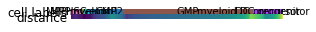

In [190]:
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        HSC, path, gene_names,
        show_node_names=True,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='viridis',
        groups_key='cell.labels',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False, normalize_to_zero_one = False)
    plt.savefig('./figures/HSC_path.pdf')
plt.show()

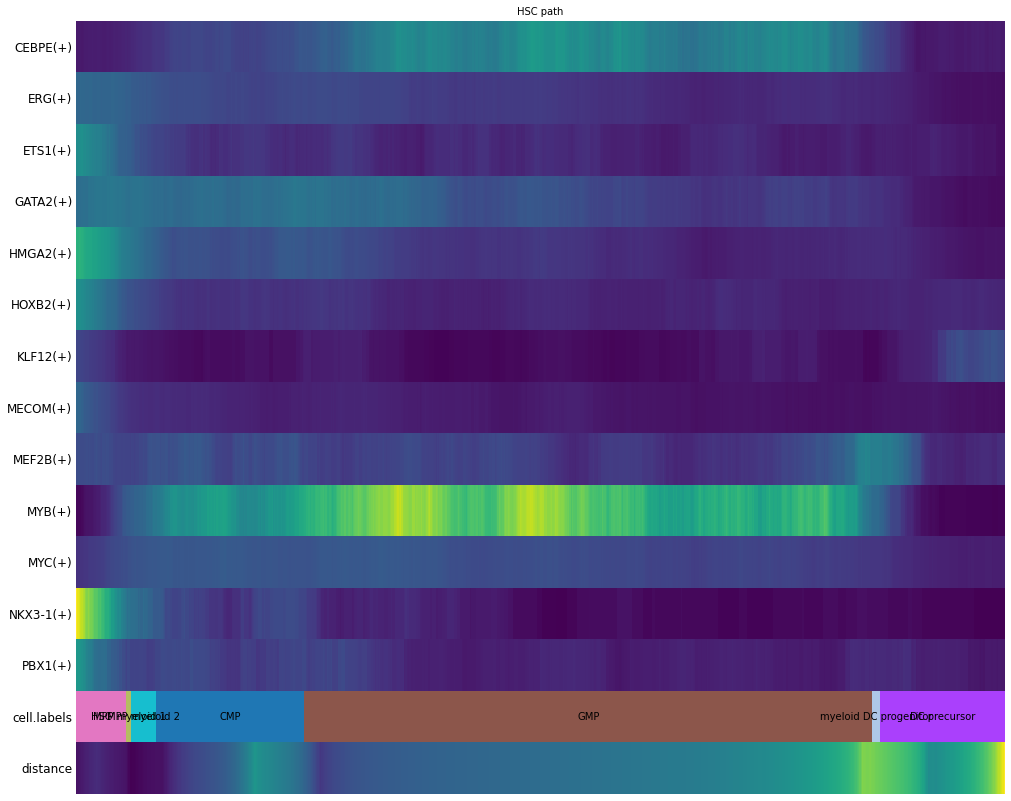

In [211]:

_, axs = plt.subplots(ncols=1, figsize=(15, 15), gridspec_kw={'wspace': 0.05, 'left': 0.12})
plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        HSC, path, gene_names,
        show_node_names=True,
   
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='viridis',
        groups_key='cell.labels',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False, normalize_to_zero_one = False)
    plt.savefig('./figures/HSC_path_filtered.pdf')
plt.show()